In [225]:
import torch
import random
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
import torch.nn.functional as F

random.seed(42)
torch.manual_seed(42)

In [226]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
device

'mps'

In [278]:
EPOCH=5000
BATCH_SIZE=64
CONTEXT_LENGTH=256
NUM_HEADS=6
HIDDEN_DIM=384
NUM_BLOCKS=6
LR=1e-3
eval_iters=100

# Read Data

In [279]:
with open('./data/input.txt', 'r') as fp:
    data = fp.readlines()

data = "".join(data)
chars = sorted(list(set("".join(data))))

len(data), len(chars)

(1115394, 65)

# Prepare Tokenizer

In [280]:
c2i = {c: i for i, c in enumerate(chars)}
i2c = {i: c for i, c in enumerate(chars)}

print("".join(chars))
print(c2i)
print(i2c)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: '

In [281]:
def encode(s):
    return [c2i[c] for c in s]

def decode(tokens):
    return "".join(i2c[ix] for ix in tokens)

# Prepare Data Split

In [282]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

len(train_data), len(val_data)

(1003854, 111540)

# Dataloader

In [283]:
class Poem(Dataset):
    def __init__(self, split):
        self.data = train_data if split == 'train' else val_data

    def __getitem__(self, idx):
        x = self.data[idx: idx+CONTEXT_LENGTH]
        y = self.data[idx+1: idx+CONTEXT_LENGTH+1]
        return x, y

    def __len__(self):
        return len(self.data) - CONTEXT_LENGTH

    def collate_fn(self, batch):
        x = [b[0] for b in batch]
        y = [b[1] for b in batch]

        tx = [encode(xx) for xx in x]
        ty = [encode(yy) for yy in y]

        return torch.tensor(tx).long(), torch.tensor(ty).long()

In [284]:
train_ds = Poem('train')
val_ds = Poem('val')

In [285]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE, collate_fn=val_ds.collate_fn)

# Model

In [286]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim, head_size, masked):
        super().__init__()
        self.Q = nn.Linear(hidden_dim, head_size, bias=False)
        self.K = nn.Linear(hidden_dim, head_size, bias=False)
        self.V = nn.Linear(hidden_dim, head_size, bias=False)

        self.hidden_dim = hidden_dim
        self.head_size = head_size
        self.masked = masked

    def forward(self, x): # B, T, D
        query = self.Q(x) # B, T, H
        key   = self.K(x) # B, T. H
        value = self.V(x) # B, T. H

        wei = torch.bmm(query, key.transpose(-2, -1)) # B, T, T
        wei = wei * (self.head_size ** 0.5)

        if self.masked:
            mask = torch.tril(torch.ones(x.size(1), x.size(1))).to(x.device)
            wei = wei.masked_fill(mask == 0, float('-inf'))

        wei = F.softmax(wei, dim=-1)

        out = torch.bmm(wei, value) # B, T, H

        return out

In [287]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads, head_size, masked):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(hidden_dim, head_size, masked) for _ in range(num_heads)])
        self.proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x =  torch.cat([h(x) for h in self.heads], dim=-1)
        x = self.proj(x)
        return x

In [288]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size, hidden_size)
        )

    def forward(self, x):
        return self.net(x)

In [289]:
class Block(nn.Module):
    def __init__(self, hidden_dim, num_heads, masked):
        super().__init__()
        self.attn = MultiHeadAttention(hidden_dim, num_heads, hidden_dim//num_heads, masked=True)
        self.fc = FeedForward(hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

    def forward(self, x): # B, T, D
        x = x + self.attn(self.ln1(x))  # B, T, D
        x = x + self.fc(self.ln2(x))    # B, T, D
        return x

In [290]:
class GPT(nn.Module):
    def __init__(self, vocab_size=len(chars), hidden_dim=HIDDEN_DIM, num_heads=NUM_HEADS, num_blocks=NUM_BLOCKS):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(vocab_size, hidden_dim)
        self.blocks = nn.ModuleList([Block(hidden_dim, num_heads, masked=True) for _ in range(num_blocks)])
        self.ln = nn.LayerNorm(hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        B, T = x.size()
        word_emb = self.word_emb(x)
        pos_emb = self.pos_emb(torch.arange(T).to(x.device))
        x = word_emb + pos_emb
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        logits = self.lm_head(x)
        return logits

    def generate(self, idx, max_new_tokens=100):
        for _ in trange(max_new_tokens):
            idx_cond = idx[:, -CONTEXT_LENGTH:] # B, T
            logits = self(idx_cond) # B, T, V
            logits = logits[:, -1, :] # B, V
            probs = F.softmax(logits, dim=-1) # B, V
            idx_next = torch.multinomial(probs, num_samples=1) # B, 1
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [295]:
model = GPT()
model = model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.715585 M parameters


# Loss and Optimizer

In [296]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [297]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
losses = []
for epoch in trange(EPOCH):
    for batch in train_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # if len(losses) % 100 == 0:
        losses.append(loss)

        break
    if len(losses) % 100 == 0:
        print(f"Epoch {epoch:5d}: Loss: {losses[-1]}")
print(f"loss: {losses[-1]}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch    99: Loss: 2.4584341049194336
Epoch   199: Loss: 2.4265639781951904
Epoch   299: Loss: 2.4923882484436035
Epoch   399: Loss: 2.519167423248291
Epoch   499: Loss: 2.504331588745117
Epoch   599: Loss: 2.467440605163574
Epoch   699: Loss: 2.58248233795166
Epoch   799: Loss: 2.550795555114746
Epoch   899: Loss: 3.003087043762207
Epoch   999: Loss: 2.535935878753662
Epoch  1099: Loss: 2.5138015747070312
Epoch  1199: Loss: 2.471226692199707
Epoch  1299: Loss: 2.5226798057556152
Epoch  1399: Loss: 2.5677647590637207
Epoch  1499: Loss: 2.553126811981201
Epoch  1599: Loss: 2.520456552505493
Epoch  1699: Loss: 2.7638235092163086
Epoch  1799: Loss: 2.54241943359375
Epoch  1899: Loss: 2.50964093208313
Epoch  1999: Loss: 2.4824211597442627
Epoch  2099: Loss: 2.4979910850524902
Epoch  2199: Loss: 2.520541191101074
Epoch  2299: Loss: 2.4692108631134033


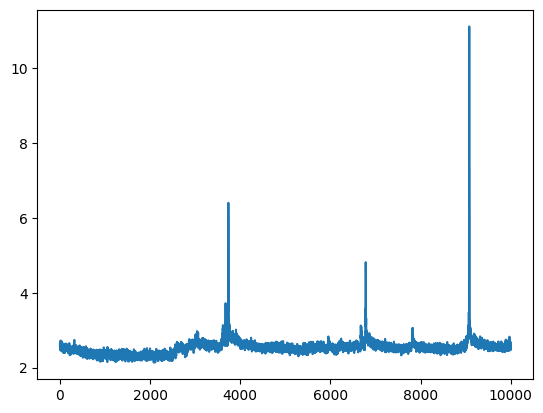

In [276]:
import matplotlib.pyplot as plt

plt.plot([torch.log(l).item() for l in losses])

In [254]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [255]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))

  0%|          | 0/2000 [00:00<?, ?it/s]


N 
i? vdeuaHr sboLot

ioIilela ' midSnt r ,tromwlc  
d tdei of'xns nodea m
hahhoaq fiaa.tsnsylo ud? gA-sn?to saddCtarfnrursMhaorya attu  taiymuat cNd a i  Hh hIiiltmpOfeN
 eeL b lr
 wNt  lhuhmcd
oefrrn  dnhekamscien;eolnhhztme
ei l,hioMR hr
dhcSymwae ory ot
 yddpweaallPl eusdrt p r
t klsro KliniaMiawhhtug: ,eaaoeia e;y  
ms  .i ntnNh 
hieRuui
s lrotm  c ht A e p.
jsy
:t  eCgEdewah Lhtoyndli
'Agencchll
o rf m 
HplfeefdGarDdaetsi d naioiA u ycltoceiu lwaTRd h s eim
Vrured c,s ut  e snrab.ioLoe or:Rmninoia  rt ro  ht

 o MAaensae oruihe,ledytSs psc irio
a aesCgsod ;Ha
h hNhoal!hgr 'edao seabrirsmnimdlojHhWrse tuiNd   i
nSav saltN, rhraNBer oaee
cvmre T' erRws r fWrdev:,owsr nrr E,alietc e
s aE  
leyps
 y
kv e Vsf hpesohhhwyMi
 !rusBdE:ixRDoesssi diRley;  lsietsa
tt  Amreak
fnanscJ
uo:mAhw
scin Kme yio lwnh aykrttmocF
 :prfqheO ew:
Roi C eeNy ea dsgihhhohEcahsacQ
enotg i's ee.avebIioeR r mvoo
enotrzNdfbetenhgohatuem y AtItg Bwirce!wtlteAmooea
yefhas I.irH,
s?nsd Ltyc o aoeesr:f
NtM reoMrn